In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
#import keras_cv

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

2023-07-19 04:35:02.263976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 04:35:02.391814: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 04:35:02.419616: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def cutout(image):
    H, W, C = image.shape
    image_cut = image.copy()
    
    count = np.random.randint(2)
    
    for _ in range(count):
        y = np.random.randint(H - 1)
        x = np.random.randint(W - 1)
        length = np.random.randint(low = W * 0.1, high = W * 0.3)

        y1 = np.clip(y - (length // 2), 0, H - 1)
        y2 = np.clip(y + (length // 2), 0, H - 1)
        x1 = np.clip(x - (length // 2), 0 ,W - 1)
        x2 = np.clip(x + (length // 2), 0, W - 1)

        image_cut[y1:y2, x1:x2, :] = 0
    
    return image_cut

def add_noise(img):
    img = img/255.0
    VARIABILITY = 0.1
    deviation = VARIABILITY * np.random.uniform()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def mixup(x, y):
    rand = np.random.uniform()
    if(rand > 0.5):
        return x, y
    alpha = 1
    lam = np.random.beta(alpha, alpha)
    ori_index = np.arange(int(len(x)))
    index = np.random.permutation(ori_index)
    mixed_x = lam * x[ori_index] + (1 - lam) * x[index]
    mixed_y = lam * y[ori_index] + (1 - lam) * y[index]

    return mixed_x, mixed_y

def mixed_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = mixup(batch_x, batch_y)
        yield batch_x, batch_y

def preproc_func(img):
    img = add_noise(img)
    img = cutout(img)
    return img

In [3]:
def mixup_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = mix_up(batch_x, batch_y)
        yield batch_x, batch_y
        
def mix_up(batch_x, batch_y):
    ori_index = np.arange(int(len(batch_x)))
    index = np.random.permutation(ori_index)
    for i in range(len(ori_index)):
        H, W, _ = batch_x[ori_index[i]].shape
        if H == 224:
            y = np.random.randint(low = 60, high = 150)
            x = np.random.randint(low = 60, high = 150)
        if H == 299:
            y = np.random.randint(low = 60, high = 200)
            x = np.random.randint(low = 60, high = 200)
        length = np.random.randint(low = 20, high = 80)

        y1 = np.clip(y - (length // 2), 0, H - 1)
        y2 = np.clip(y + (length // 2), 0, H - 1)
        x1 = np.clip(x - (length // 2), 0 ,W - 1)
        x2 = np.clip(x + (length // 2), 0, W - 1)
        
        tmp = np.random.randint(2)
        
        if tmp == 0:
            batch_x[ori_index[i]][y1:y2, x1:x2, :] = batch_x[index[i]][0:y2-y1, 0:x2-x1, :]
        else:
            batch_x[ori_index[i]][y1:y2, x1:x2, :] = batch_x[index[i]][H-(y2-y1):H, W-(x2-x1): W, :]
    return batch_x, batch_y

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    #rescale = 1/255.
     rotation_range = 15
    , shear_range = 0.15
    , zoom_range = 0.15
    , horizontal_flip = True
    , brightness_range=[0.9, 1.015]
    , preprocessing_function = add_noise
)

valid_generator = ImageDataGenerator(
    rescale=1/255.
)

## Inception

In [15]:
import wandb

wandb.init(
    project="bird",
    name="inception_v1_ls",
    config={
        "epochs": 200,
        "batch_size": 16,
        "config":"label_smoothing, alpha_blending, cutmix, spatial_dropout"
    }
)

accuracy,▁▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇███████▇██████████
val_loss,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.91354
best_epoch,37
best_val_loss,1.74353
epoch,99
loss,1.0962
val_accuracy,0.56453


### Inception_V1

In [16]:
train_dst = train_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/train'
    , target_size = (224, 224)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

valid_dst = valid_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/valid'
    , target_size = (224, 224)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

Found 10650 images belonging to 200 classes.
Found 1139 images belonging to 200 classes.


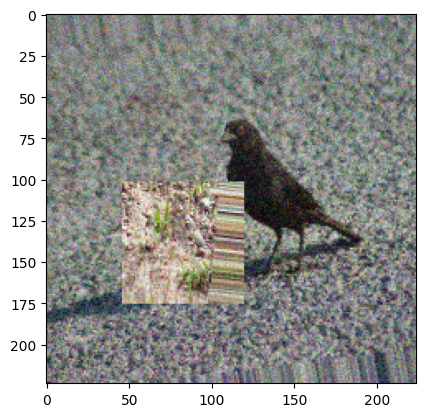

In [17]:
images, labels = next(train_dst)
dst = mixed_generator(train_dst)
dst = mixup_generator(dst)
images, labels = next(dst)
# print(labels)

plt.imshow(images[0])
plt.show()

In [18]:
# Initialize step(mixup 할 때 설정 필요)

import os
# data_dir 디렉토리 아래의 모든 디렉토리와 파일을 탐색
# total_data = sum([len(files) for r, d, files in os.walk(data_dir)])
total_data = 11807
valid_data_rate = 0.1
batch_size = 16

total_train_data = total_data * (1 - valid_data_rate)
total_valdation_data = total_data * valid_data_rate

steps_per_epoch = total_train_data // batch_size
validation_steps = total_valdation_data // batch_size

In [19]:
def y_repeat(batch_x, batch_y):
    new_batch_y = np.ndarray(shape=(batch_y.shape[0], 600))
    for i in range(len(batch_y)):
        new_y = tf.repeat(batch_y[i], 3)
        new_batch_y[i] = new_y
    return batch_x, new_batch_y

def y_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = y_repeat(batch_x, batch_y)
        yield batch_x, batch_y
        
#t_dst = y_generator(dst)
#v_dst = y_generator(valid_dst)

In [22]:
def inception3a(x):
    x1 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(x)
    
    x2 = Conv2D(96, (1, 1), padding = 'same', activation = 'relu')(x)
    x2 = Covn2D(128, (3, 3), padding = 'same', activation = 'relu')(x2)
    
    x3 = Conv2D(16, (1, 1), padding = 'same', activation = 'relu')(x)
    x3 = Conv2D(32, (5, 5), padding = 'same', activation = 'relu')(x3)
    
    x4 = MaxPool2D((3, 3), 1, padding = 'same')(x)
    x4 = Conv2D(32, (1, 1), padding = 'same', activation = 'relu')(x4)
    
    return Concatenate()([x1, x2, x3, x4])

def inception_block(filters, x):
    x1 = Conv2D(filters[0], 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x1 = BatchNormalization()(x1)
    
    x2 = Conv2D(filters[1][0], 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x2 = Conv2D(filters[1][1], 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)
    x2 = BatchNormalization()(x2)
    
    x3 = Conv2D(filters[2][0], 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x3 = Conv2D(filters[2][1], 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = BatchNormalization()(x3)
    
    x4 = MaxPool2D((3, 3), 1, padding = 'same')(x)
    x4 = Conv2D(filters[3], 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x4)
    x4 = BatchNormalization()(x4)
    
    x = Concatenate()([x1, x2, x3, x4])
    x = SpatialDropout2D(0.2)(x)
    return x
    

def auxiliary_classifer(filters, x):
    x = AveragePooling2D((5, 5), 3)(x)
    x = Conv2D(filters, 1, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = Dropout(0.7)(x)
    return Dense(200, activation = 'softmax')(x)
    

In [23]:
inputs = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
x = MaxPooling2D((3, 3), 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(192, (3, 3), 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
x = MaxPooling2D((3, 3), 2, padding = 'same')(x)
x = BatchNormalization()(x)

x = inception_block([64, [96, 128], [16, 32], 32], x)
x = inception_block([128, [128, 192], [32, 96], 64], x)
x = MaxPooling2D((3, 3), 2, padding = 'same')(x)
x = BatchNormalization()(x)

x = inception_block([192, [96, 208], [16, 48], 64], x)
x1_output = auxiliary_classifer(512, x)
x = inception_block([160, [112, 224], [24, 64], 64], x)
x = inception_block([128, [128, 256], [24, 64], 64], x)
x = inception_block([112, [144, 288], [32, 64], 64], x)
x2_output = auxiliary_classifer(528, x)
x = inception_block([256, [160, 320], [32, 128], 128], x)
x = MaxPooling2D((3, 3), 2, padding = 'same')(x)

x = inception_block([256, [160, 320], [32, 128], 128], x)
x = inception_block([384, [192, 384], [48, 128], 128], x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

x = Dense(1024)(x)
x3_output = Dense(200, activation = 'softmax')(x)

output = Concatenate()([x1_output, x2_output, x3_output])

inception_v1 = Model(inputs, x3_output)
inception_v1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_56[0][0]']              
                                                                                            

In [24]:
initial_lr = 0.001
decay_rate = 0.96
steps = 667
epochs = 100
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.SGD(momentum = 0.9, learning_rate=lr_schedule)

inception_v1.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
                #loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              metrics = ['accuracy'])

In [26]:
hist = inception_v1.fit(
    dst,
    steps_per_epoch = steps_per_epoch,
    epochs = 200,
    verbose = 1,
    validation_data = valid_dst,
    callbacks = [wandb.keras.WandbCallback(save_model = False)]
)

Epoch 1/200
664/664 [==============================] - 156s 235ms/step - loss: 2.3780 - accuracy: 0.7043 - val_loss: 1.9800 - val_accuracy: 0.6822
Epoch 2/200
664/664 [==============================] - 156s 235ms/step - loss: 2.3962 - accuracy: 0.7118 - val_loss: 2.0072 - val_accuracy: 0.6734
Epoch 3/200
664/664 [==============================] - 155s 234ms/step - loss: 2.4644 - accuracy: 0.7018 - val_loss: 2.0014 - val_accuracy: 0.6839
Epoch 4/200
664/664 [==============================] - 156s 235ms/step - loss: 2.4308 - accuracy: 0.7031 - val_loss: 2.0868 - val_accuracy: 0.6778
Epoch 5/200
664/664 [==============================] - 155s 234ms/step - loss: 2.3870 - accuracy: 0.7079 - val_loss: 2.0208 - val_accuracy: 0.6769
Epoch 6/200
664/664 [==============================] - 156s 235ms/step - loss: 2.3601 - accuracy: 0.7143 - val_loss: 1.9945 - val_accuracy: 0.6804
Epoch 7/200
664/664 [==============================] - 157s 236ms/step - loss: 2.4480 - accuracy: 0.6990 - val_loss: 2

KeyboardInterrupt: 

### Inception_v4

In [14]:
train_dst = train_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/train'
    , target_size = (299, 299)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

valid_dst = valid_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/valid'
    , target_size = (299, 299)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

dst = mixed_generator(train_dst)
dst = mixup_generator(dst)

Found 10650 images belonging to 200 classes.
Found 1139 images belonging to 200 classes.


In [7]:
def stem(x):
    x = Conv2D(32, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    x = Conv2D(32, 3, 1, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = Conv2D(64, 3, 1, padding = 'same', activation = 'relu', kernel_initializer = "he_normal")(x)
    
    branch1 = MaxPool2D((3, 3), 2)(x)
    branch2 = Conv2D(96, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = Concatenate()([branch1, branch2])
    
    branch1 = Conv2D(64, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    branch1 = Conv2D(96, 3, activation = 'relu', kernel_initializer = 'he_normal')(branch1)
    
    branch2 = Conv2D(64, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    branch2 = Conv2D(64, (7, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(branch2)
    branch2 = Conv2D(64, (1, 7), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(branch2)
    branch2 = Conv2D(96, 3, activation = 'relu', kernel_initializer = 'he_normal')(branch2)
    x = Concatenate()([branch1, branch2])
    
    branch1 = Conv2D(192, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    branch2 = MaxPool2D(strides = 2)(x)
    x = Concatenate()([branch1, branch2])
    x = SpatialDropout2D(0.2)(x)
    return BatchNormalization()(x)
    
def inception_block_A(x):
    x1 = Conv2D(96, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x2 = Conv2D(64, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x2 = Conv2D(96, 3, padding = 'same',activation = 'relu', kernel_initializer = 'he_normal')(x2)
    
    x3 = Conv2D(64, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x3 = Conv2D(96, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(96, 3, padding = 'same',activation = 'relu', kernel_initializer = 'he_normal')(x3)
    
    x4 = AveragePooling2D(strides = 1, padding = 'same')(x)
    x4 = Conv2D(96, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x4)
    
    x = Concatenate()([x1, x2, x3, x4])
    x = SpatialDropout2D(0.2)(x)
    return BatchNormalization()(x)

def inception_block_B(x):
    x1 = Conv2D(384, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x2 = Conv2D(192, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x2 = Conv2D(224, (7, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)
    x2 = Conv2D(256, (1, 7), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)
    
    x3 = Conv2D(192, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x3 = Conv2D(192, (1, 7), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(224, (7, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(224, (1, 7), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(256, (7, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    
    x4 = AveragePooling2D(strides = 1, padding = 'same')(x)
    x4 = Conv2D(128, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x4)
    
    x = Concatenate()([x1, x2, x3, x4])
    x = SpatialDropout2D(0.2)(x)
    return BatchNormalization()(x)

def inception_block_C(x):
    x1 = Conv2D(256, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x2 = Conv2D(384, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x2 = Conv2D(448, (1, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)
    x2 = Conv2D(512, (3, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)
    x2_1 = Conv2D(256, (3, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)
    x2_2 = Conv2D(256, (1, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x2)

    x3 = Conv2D(384, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x3_1 = Conv2D(256, (1, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3_2 = Conv2D(256, (3, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
  
    x4 = AveragePooling2D(strides = 1, padding = 'same')(x)
    x4 = Conv2D(256, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x4)
   
    x = Concatenate()([x1, x2_1, x2_2, x3_1, x3_2, x4])
    x = SpatialDropout2D(0.2)(x)
    return BatchNormalization()(x)

In [8]:
def reduction_A(x):
    x1 = MaxPool2D((3, 3), 2)(x)
    
    x2 = Conv2D(384, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x3 = Conv2D(192, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x3 = Conv2D(224, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(156, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(x3)
    
    x = Concatenate()([x1, x2, x3])
    x = SpatialDropout2D(0.2)(x)
    return BatchNormalization()(x)

def reduction_B(x):
    x1 = MaxPool2D((3, 3), 2)(x)
    
    x2 = Conv2D(192, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x2 = Conv2D(192, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(x2)
    
    x3 = Conv2D(256, 1, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x3 = Conv2D(256, (1, 7), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(320, (7, 1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x3)
    x3 = Conv2D(320, 3, 2, activation = 'relu', kernel_initializer = 'he_normal')(x3)
    
    x = Concatenate()([x1, x2, x3])
    x = SpatialDropout2D(0.2)(x)
    return BatchNormalization()(x)

In [9]:
inputs = Input(shape=(299, 299, 3))

x = stem(inputs)
for _ in range(1): #4
    x = inception_block_A(x)
x = reduction_A(x)
for _ in range(1): #7
    x = inception_block_B(x)
x = reduction_B(x)
for _ in range(1): #3
    x = inception_block_C(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(200, activation = 'softmax')(x)

inception_v4 = Model(inputs, output)

inception_v4.summary()

2023-07-19 04:35:46.345088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 04:35:46.799012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 147, 147, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [10]:
initial_lr = 0.0001
decay_rate = 0.98
steps = 667
epochs = 100
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=lr_schedule)

inception_v4.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              metrics = ['accuracy'])

In [ ]:
hist = inception_v4.fit(
    dst,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    verbose = 1,
    validation_data = valid_dst,
    callbacks = [wandb.keras.WandbCallback(save_model=False)]
)

Epoch 1/100


2023-07-19 04:36:07.528454: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-07-19 04:36:09.060204: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


664/664 [==============================] - 262s 385ms/step - loss: 5.2004 - accuracy: 0.0200 - val_loss: 6.1213 - val_accuracy: 0.0167
Epoch 2/100
664/664 [==============================] - 255s 385ms/step - loss: 4.8095 - accuracy: 0.0446 - val_loss: 4.6665 - val_accuracy: 0.0518
Epoch 3/100
664/664 [==============================] - 254s 383ms/step - loss: 4.5168 - accuracy: 0.0727 - val_loss: 4.2372 - val_accuracy: 0.0808
Epoch 4/100
664/664 [==============================] - 254s 384ms/step - loss: 4.2941 - accuracy: 0.1054 - val_loss: 3.9120 - val_accuracy: 0.1343
Epoch 5/100
664/664 [==============================] - 254s 383ms/step - loss: 4.0658 - accuracy: 0.1441 - val_loss: 3.7798 - val_accuracy: 0.1747
Epoch 6/100
664/664 [==============================] - 254s 384ms/step - loss: 3.6972 - accuracy: 0.2155 - val_loss: 3.4548 - val_accuracy: 0.2098
Epoch 8/100
664/664 [==============================] - 255s 385ms/step - loss: 3.5648 - accuracy: 0.2456 - val_loss: 3.5122 - val_

In [ ]:
# Batch Norm
# outlier에 편향. -> outlier를 없애는 선택 
# task가 간단하고 특징이 명확할 때 R -> B : ex - Dimension Reduction -> PCA, t-SNE
# 그 반대일 때 B -> R